# Analysis Graphing for Completed XPOT Runs

This script allows you to identify the best iteration of any given XPOT optimization sweep, and run dimer and force curve analysis on them. 

Derivations of some of these functions are expected to be included in the automated workflow in future versions.

In [7]:
import pandas as pd
from ase.io import read, write
from quippy.potential import Potential
import numpy as np
from ase.calculators.lammpslib import LAMMPSlib
from ase import Atoms
import matplotlib.pyplot as plt

def read_run_data(out_dir):
    out_params = pd.read_csv(f"{out_dir}/params.csv")
    out_errors = pd.read_csv(f"{out_dir}/errors.csv")
    best_iteration_idx = out_params["loss"].idxmin()
    best_iteration = out_params.iloc[best_iteration_idx]["iteration"]
    best_iteration_path = f"{out_dir}/{int(best_iteration)}"
    print("Folder containing best iteration: " + best_iteration_path)

**The best numerical potential is found from the optimization sweep folder from XPOT**

In [8]:
read_run_data("../../../q_12_gap17_rcut_free_fixed")

Folder containing best iteration: ../../../q_12_gap17_rcut_free_fixed/66


In [9]:
def dimer_curve_gap(potential_file, cutoff, dimer_makeup, sample_density, ref_e=0):
    gap_energies = []
    gap_distances = [x for x in np.linspace(0.2, cutoff, num=int((cutoff-0.2)//sample_density))]
    potential = Potential(param_filename=potential_file)
    dimers = [Atoms(dimer_makeup, positions=[[0,0,0],[0,0,x]]) for x in gap_distances]
    for dimer in dimers:
        dimer.set_cell([20,20,20])
        dimer.calc = potential
        gap_energies.append(dimer.get_potential_energy()/2 - ref_e)

    results = {
        "ml_e": gap_energies,
        "ml_d": gap_distances
    }
    
    return results

def dimer_curve_snap(potential_file, cutoff, dimer_makeup, sample_density, lmp_cmds, ref_e=0):
    snap_energies = []
    snap_distances = [x for x in np.linspace(0.2, cutoff, num=int((cutoff-0.2)//sample_density))]
    cmds = [i.replace("file_name", potential_file) for i in lmp_cmds]
    print(cmds)
    potential = LAMMPSlib(lmpcmds=cmds, keep_alive=True)
    dimers = [Atoms(dimer_makeup, positions=[[0,0,0],[0,0,x]]) for x in snap_distances]
    for dimer in dimers:
        dimer.set_cell([20,20,20])
        dimer.calc = potential
        snap_energies.append(dimer.get_potential_energy()/2 - ref_e)

    results = {
        "ml_e": snap_energies,
        "ml_d": snap_distances
    }

    return results

def dimer_curve_plot(method, potential_file, cutoff, dimer_makeup, sample_density=0.05, ref_e=0, lmp_cmds=None, dft_data=None, ylims=None):
    if method == "SNAP":
        ml_results = dimer_curve_snap(potential_file, cutoff, dimer_makeup, sample_density, lmp_cmds, ref_e=ref_e)
    elif method == "GAP":
        ml_results = dimer_curve_gap(potential_file, cutoff, dimer_makeup, sample_density, ref_e=ref_e)
    else:
        print("Error, method not recognised, use string GAP or SNAP")
        exit
    
    fig, ax1 = plt.subplots()
    ax1.set_ylabel("Energy (eV/atom)")
    e1, = ax1.plot(ml_results["ml_d"], ml_results["ml_e"], "-",label="method", color="orangered", linewidth=1.5)
    if dft_data:
        dft_energies = []
        dft_distances = []
        dft_data = read(dft_data, index=":")
        for dimer in dft_data:
            dft_energies.append(dimer.get_potential_energy()/2 - ref_e)
            dft_distances.append(dimer.get_distance(0,1))
        e2, = ax1.plot(dft_distances, dft_energies, "-+",label="DFT", color="black", linewidth=1)
        plt.legend([e2, e1], ["DFT", method], loc="upper right")
    else:
        plt.legend([e1], [method], loc="upper right")
    plt.title(f"Dimer Curve for {method} potential")
    ax1.set_xlabel("Distance (Å)")
    ax1.set_xlim(0.2,cutoff)
    if ylims:
        ax1.set_ylim(ylims[0], ylims[1])
    #plt.savefig("dimer_curve.png", dpi=300)
    plt.show()

**We show here the dimer curves for a SNAP C potential, taken from the best potential found by XPOT**

N.B. The name of the potential file for snap does not include the file extension (due to two files used). For GAP, the file extension is included. (e.g. gap_potential.xml)

['pair_style hybrid/overlay zbl 0.5 1.0 snap', 'pair_coeff 1 1 zbl 6 6', 'pair_coeff * * snap ../../../q_12_gap17_rcut_free_fixed/66/q_12_gap17_rcut.snapcoeff ../../../q_12_gap17_rcut_free_fixed/66/q_12_gap17_rcut.snapparam C']


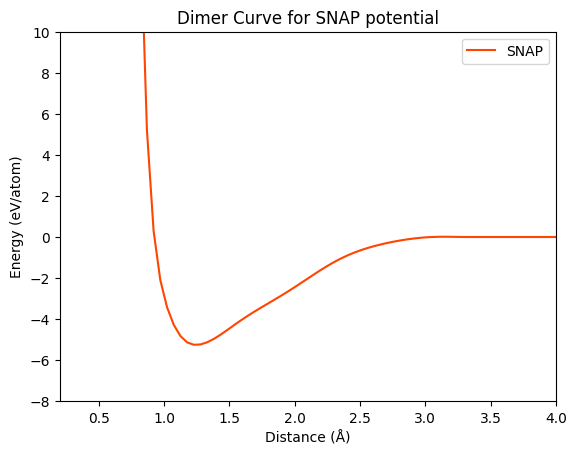

<Figure size 640x480 with 0 Axes>

In [10]:
lmp_cmds_all=["pair_style hybrid/overlay zbl 0.5 1.0 snap","pair_coeff 1 1 zbl 6 6","pair_coeff * * snap file_name.snapcoeff file_name.snapparam C"]

dimer_curve_plot("SNAP", "../../../q_12_gap17_rcut_free_fixed/66/q_12_gap17_rcut", 
    4, "C2", lmp_cmds=lmp_cmds_all, ref_e=0, ylims=[-8,10])

In [13]:
def parse_e_f_gap(potential_file, dft_data, ref_e=0):
    gap_energies = []
    gap_force_components = []
    dft_energies = []
    dft_force_components = []
    potential = Potential(param_filename=potential_file)
    structures = read(dft_data, index=":")
    for struct in structures:
        dft_force_components.append(struct.get_forces())
        dft_energies.append(struct.get_potential_energy()/len(struct))
        struct.calc = potential
        gap_energies.append(struct.get_potential_energy()/len(struct))
        gap_force_components.append(struct.get_forces())

    results = {
        "ml_e": gap_energies,
        "ml_f": np.concatenate(gap_force_components).ravel().tolist(),
        "dft_e": dft_energies, 
        "dft_f": np.concatenate(dft_force_components).ravel().tolist()
    }
    
    return results

def parse_e_f_snap(potential_file, dft_data, lmp_cmds=None, ref_e=0):
    snap_energies = []
    snap_force_components = []
    dft_energies = []
    dft_force_components = []
    cmds = [i.replace("file_name", potential_file) for i in lmp_cmds]
    potential = LAMMPSlib(lmpcmds=cmds, keep_alive=True)
    structures = read(dft_data, index=":")
    for struct in structures:
        dft_force_components.append(struct.arrays["forces"])
        dft_energies.append(struct.info["energy"]/len(struct))
        struct.calc = potential
        snap_energies.append(struct.get_potential_energy()/len(struct) + ref_e)
        snap_force_components.append(struct.get_forces())

    results = {
        "ml_e": snap_energies,
        "ml_f": np.concatenate(snap_force_components).ravel().tolist(),
        "dft_e": dft_energies, 
        "dft_f": np.concatenate(dft_force_components).ravel().tolist()
    }
    
    return results

def e_f_error_plots(method, potential_file, dft_data, lmp_cmds=None, ref_e=0):
    if method == "GAP":
        ml_results = parse_e_f_gap(potential_file, dft_data, ref_e=ref_e)
    elif method == "SNAP":
        ml_results = parse_e_f_snap(potential_file, dft_data, lmp_cmds=lmp_cmds, ref_e=ref_e)
    else:
        print("Fail, method is not supported, use str GAP or SNAP.")
        exit

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
    ax1.set_title(f"{method} vs DFT Energy per atom")
    ax2.set_title(f"{method} vs DFT Force Components")
    ax1.scatter(ml_results["dft_e"], ml_results["ml_e"], s=0.1)
    ax1.set_xlabel("DFT Energy (eV/atom)")
    ax1.set_ylabel(f"{method} Energy (eV/atom)")
    ax2.scatter(ml_results["dft_f"], ml_results["ml_f"], s=0.1)
    ax2.set_xlabel("DFT Force Components (eV/Å)")
    ax2.set_ylabel(f"{method} Force Components (eV/Å)")
    #plt.savefig(f"xpot_energy_force_{method}.png")
    plt.show()

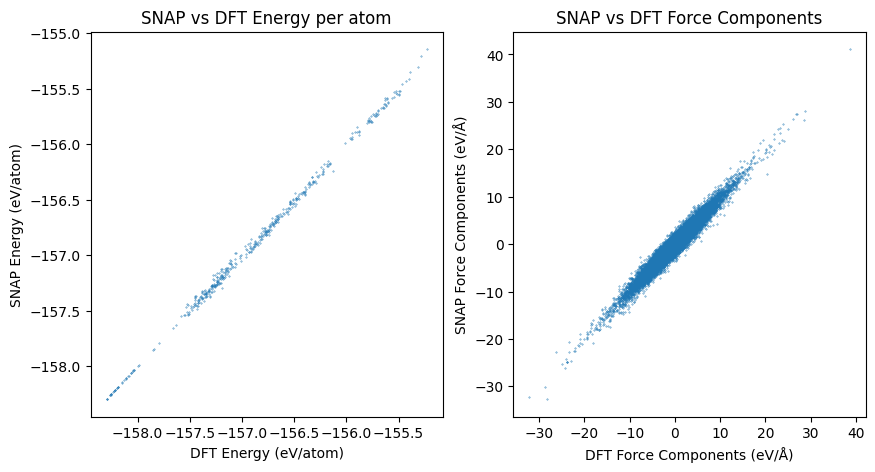

<Figure size 640x480 with 0 Axes>

In [14]:
e_f_error_plots("SNAP", "../../../q_12_gap17_rcut_free_fixed/66/q_12_gap17_rcut","../../../q_12_gap17_rcut_free_fixed/split_test.xyz", lmp_cmds=lmp_cmds_all, ref_e=-148.314002)